In [8]:
# Importing necessary libraries
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor

from treemind.algorithm import Explainer
from treemind.plot import interaction_scatter_plot

import seaborn as sns
import matplotlib.pyplot as plt
import shap

from typing import Tuple

from matplotlib.colors import TwoSlopeNorm

In [9]:
def feature_plot(
    df: pd.DataFrame,
    col_max,
    col_min,
    figsize: Tuple[int, int] = (10, 6),
    show_min_max: bool = False,
    title_fontsize: float = 16.0,
    label_fontsizes: float = 14.0,
    title: str | None = None,
    xlabel: str | None = None,
    ylabel: str | None = None,
) -> None:
    """
    Plots the mean, min, and max values of a feature based on tree split points.

    This method takes as input the output DataFrame from the `analyze_feature`
    method of the `treemind.Explainer` class (`analyze_feature(self, col: int) -> pd.DataFrame`).

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the feature data with the following columns:
        - 'feature_lb': Lower bound of the feature range (tree split point).
        - 'feature_ub': Upper bound of the feature range (tree split point).
        - 'mean': Mean value of the feature within this range.
        - 'min': Minimum value of the feature within this range.
        - 'max': Maximum value of the feature within this range.
    figsize : tuple of int, optional, default (10.0, 6.0)
        Width and height of the plot in inches.
    show_min_max : bool, optional, default False
        If True, shaded areas representing the min and max values will be displayed.
    xticks_n : int, optional, default 10
        Number of tick marks to display on the x-axis.
    yticks_n : int, optional, default 10
        Number of tick marks to display on the y-axis.
    ticks_decimal : int, optional, default 3
        Number of decimal places for tick labels
    ticks_fontsize : float, optional, default 10.0
        Font size for axis tick labels,
    title_fontsize : float, optional, default 16.0
        Font size for the plot title.
    title : str, optional, default None
        The title displayed at the top of the plot. If `None`, no title is shown.
    xlabel : str, optional, default None
        Label for the x-axis. If None, it will default to the feature name.
    ylabel : str, optional, default None
        Label for the y-axis. Defaults to "Value" if not specified.

    Returns
    -------
    None
        Displays the plot.
    """

    # Validate parameters

    column_name = df.columns[1]

    df.loc[np.isposinf(df[column_name]), column_name] = col_max

    # Set default labels if None
    xlabel = xlabel if xlabel is not None else column_name[:-3]
    ylabel = ylabel if ylabel is not None else "Value"

    extend_ratio = 0.05 * (df[column_name].max() - df[column_name].min())

    min_row = df.iloc[df[column_name].argmin()].copy()
    min_row[column_name] = col_min

    max_row = df.iloc[df[column_name].argmax()].copy()
    max_row[column_name] += extend_ratio

    df = pd.concat([min_row.to_frame().T, df], ignore_index=True)

    plt.figure(figsize=figsize)

    sns.lineplot(
        data=df,
        x=column_name,
        y="mean",
        color="blue",
        linewidth=2,
        drawstyle="steps-pre",
    )

    if show_min_max:
        plt.fill_between(
            df[column_name],
            df["min"],
            df["max"],
            color="gray",
            alpha=0.3,
            label="Min-Max Range",
            step="post",
        )

    # Set the plot title
    if title is None:
        plt.title(
            f"Contribution of {xlabel}", fontsize=title_fontsize, fontweight="bold"
        )
    else:
        plt.title(title, fontsize=title_fontsize, fontweight="bold")

    plt.gca().set_facecolor("whitesmoke")

    plt.xlabel(xlabel, fontsize=label_fontsizes)
    plt.ylabel(ylabel, fontsize=label_fontsizes)

    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

    if show_min_max:
        plt.legend()

    plt.tight_layout()
    plt.show()

In [10]:
# Functions for plotting real data:
# - _set_common_style: Applies a consistent visual style to all plots to match the style used by TreeMind.
# - plot_line_chart: Creates a line chart to visualize trends in data over a continuous range.
# - plot_scatter_chart: Generates a scatter plot to explore relationships between two variables, with a third variable indicated by color.


def _set_common_style(ax, title):
    ax.set_facecolor("whitesmoke")
    ax.set_title(title, fontsize=16, fontweight="bold")
    ax.set_xlabel(ax.get_xlabel(), fontsize=14)
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)
    ax.tick_params(axis="both", which="major", labelsize=10)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)


def plot_line_chart(x, y, title, x_label, y_label, figsize: Tuple[int, int] = (10, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.lineplot(x=x, y=y, ax=ax, color="blue", linewidth=2)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    _set_common_style(ax, title)
    plt.tight_layout()
    plt.show()


def plot_scatter_chart(
    x, y, z, title, x_label, y_label, cbar_label, figsize: Tuple[int, int] = (10, 6)
):
    fig, ax = plt.subplots(figsize=figsize)

    max_val = z.max()
    min_val = z.min()

    if max_val < 0:  # All values are negative
        colormap = plt.get_cmap("Blues")
        norm = plt.Normalize(vmin=min_val, vmax=max_val)
    elif min_val > 0:  # All values are positive
        colormap = plt.get_cmap("Reds")
        norm = plt.Normalize(vmin=min_val, vmax=max_val)
    else:  # Both negative and positive values
        colormap = plt.get_cmap("coolwarm")
        abs_max = max(abs(min_val), max_val)
        norm = TwoSlopeNorm(vmin=-abs_max, vcenter=0, vmax=abs_max)

    scatter = ax.scatter(x, y, c=z, cmap=colormap, norm=norm, edgecolor="k")

    cbar = plt.colorbar(scatter, ax=ax)

    cbar.ax.set_yscale("linear")
    cbar.ax.set_ylim(min_val, max_val)
    cbar.set_label(cbar_label)

    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)

    _set_common_style(ax, title)

    plt.tight_layout()
    plt.show()

In [15]:
n_samples = 12000

np.random.seed(42)  # Setting a random seed for reproducibility

# Base features with diverse probability distributions
feature_0 = np.random.gamma(shape=2, scale=2, size=n_samples)  # Gamma distribution
feature_1 = np.random.beta(2, 5, size=n_samples) * 10  # Beta distribution scaled
feature_2 = np.random.exponential(scale=1.5, size=n_samples)  # Exponential
feature_3 = np.random.chisquare(df=3, size=n_samples)  # Chi-square
feature_4 = np.random.weibull(1.5, size=n_samples)  # Weibull
feature_5 = np.random.normal(loc=2, scale=1.5, size=n_samples)  # Normal
feature_6 = np.random.uniform(low=-5, high=5, size=n_samples)  # Uniform
feature_7 = np.random.laplace(loc=0, scale=2, size=n_samples)  # Laplace
feature_8 = np.random.lognormal(mean=0, sigma=0.5, size=n_samples)  # Log-normal

# Complex non-linear transformations
transformed_0 = np.log1p(feature_0) * np.sqrt(feature_0)
transformed_1 = np.exp(-feature_1 / 5) * np.sin(feature_1)
transformed_2 = np.tanh(feature_2) * feature_2 ** 1.5
transformed_3 = np.sqrt(np.abs(feature_3)) * np.cos(feature_3)
transformed_4 = np.sinh(feature_4) / (1 + feature_4 ** 2)
transformed_5 = np.where(
    feature_5 > 0,
    feature_5  * np.sin(feature_5),  # Applies log1p only for positive values
    np.log1p(np.abs(feature_5)) * np.cos(feature_5)  # Takes abs for negative values
)
transformed_6 = np.sign(feature_6) * np.abs(feature_6) ** (2 / 3)
transformed_7 = np.exp(-np.abs(feature_7)) * np.cos(feature_7 * np.pi / 2)
transformed_8 = np.log(feature_8 + 1) * np.sin(feature_8)

# New pairwise interactions
interaction_0_2 = transformed_0 * transformed_2 / (1 + np.abs(transformed_0 + transformed_2))
interaction_1_3 = np.maximum(transformed_1, transformed_3) - np.minimum(transformed_1, transformed_3)
interaction_4_6 = np.sign(transformed_4 + transformed_6) * np.sqrt(np.abs(transformed_4 * transformed_6))
interaction_5_7 = np.log1p(np.abs(transformed_5 - transformed_7))
interaction_6_8 = np.exp(-np.abs(transformed_6)) * np.sin(transformed_8)

# Generated target with new interactions
target = target = (
    0.4 * transformed_0
    - 0.6 * transformed_1
    + 0.3 * transformed_2
    + 0.5 * transformed_3
    - 0.4 * transformed_4
    + 0.7 * transformed_5
    - 0.3 * transformed_6
    + 0.5 * transformed_7
    - 0.4 * transformed_8
    + 0.6 * interaction_0_2
    - 0.5 * interaction_1_3
    + 0.4 * interaction_4_6
    - 0.3 * interaction_5_7
    + 0.5 * interaction_6_8
    + np.random.normal(loc=0, scale=0.2, size=n_samples)  # Biraz daha noise ekledim
)

# Add some outliers
outlier_idx = np.random.choice(n_samples, size=int(n_samples * 0.01), replace=False)
target[outlier_idx] += np.random.normal(loc=0, scale=5, size=len(outlier_idx))

# Create DataFrame with all features
df = pd.DataFrame(
    {
        "feature_0": feature_0,
        "feature_1": feature_1,
        "feature_2": feature_2,
        "feature_3": feature_3,
        "feature_4": feature_4,
        "feature_5": feature_5,
        "feature_6": feature_6,
        "feature_7": feature_7,
        "feature_8": feature_8,
        "target": target,
    }
)

X = df.drop('target', axis=1).values
y = df['target'].values

In [38]:
# Train a LightGBM model
reg = LGBMRegressor(verbose=-1, n_estimators=500, num_leaves=75, learning_rate=0.02)
reg.fit(X, y)  #

# Use treemind's Explainer to analyze the trained model
explainer = Explainer()
explainer(reg)

# Use shap's TreeExplainer to analyze the trained model
shap_explainer = shap.TreeExplainer(reg)
shap_values = shap_explainer(X)
shap_interaction_values = shap_explainer.shap_interaction_values(X)

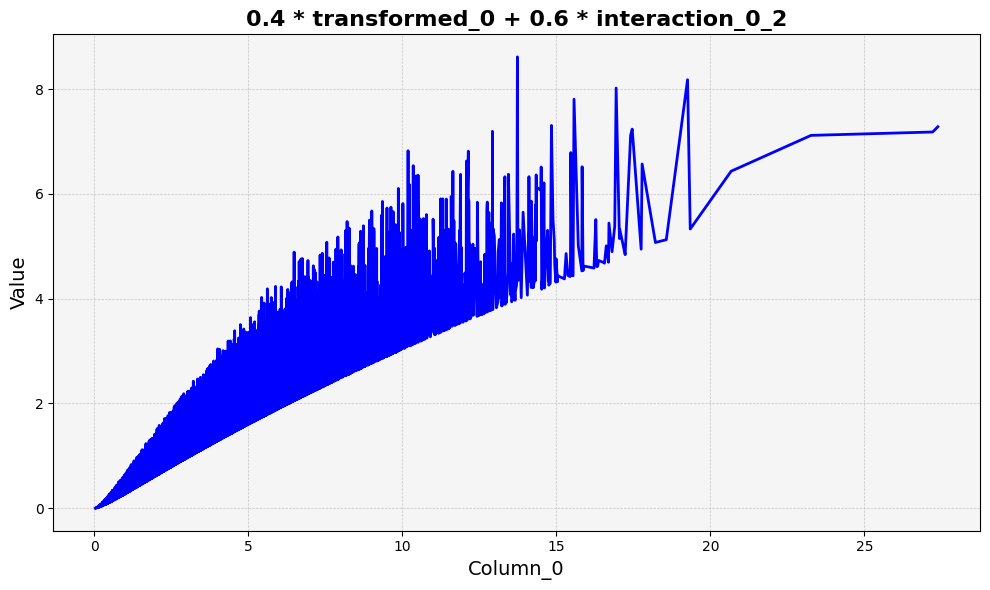

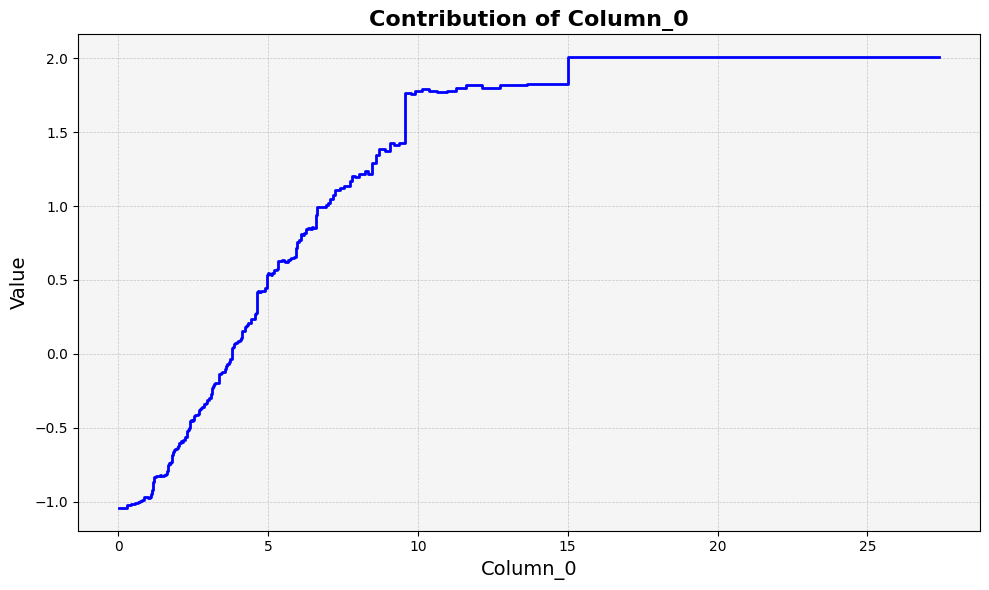

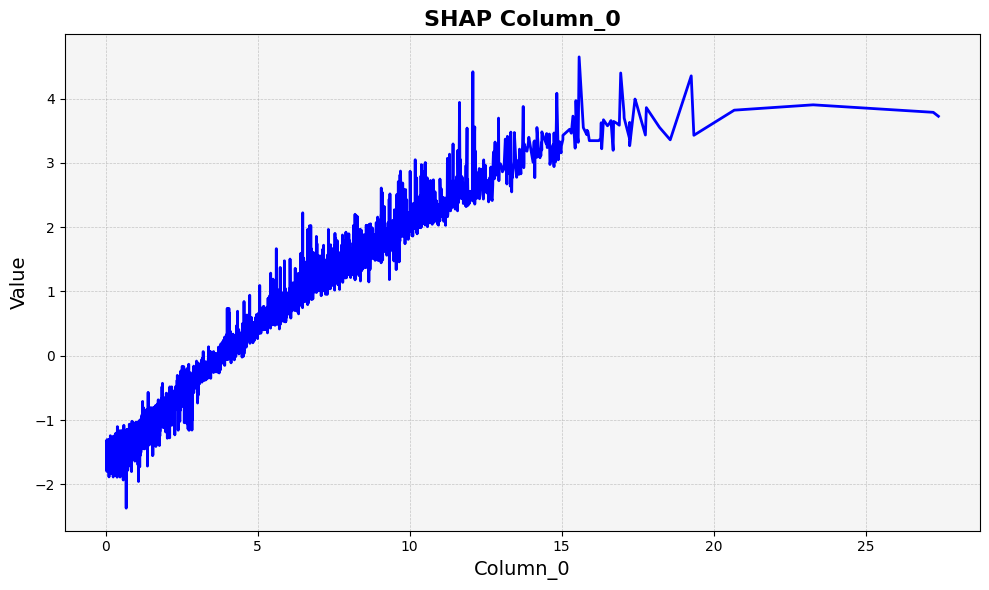

In [39]:
# Feature 0 Analysis
feature_df_0 = explainer.analyze_feature(0)
plot_line_chart(
    x=feature_0,
    y=0.4 * transformed_0 + 0.6 * interaction_0_2,
    x_label="Column_0",
    y_label="Value",
    title="0.4 * transformed_0 + 0.6 * interaction_0_2",
)
feature_plot(
    feature_df_0, show_min_max=False, col_min=X[:, 0].min(), col_max=X[:, 0].max()
)
plot_line_chart(
    x=feature_0,
    y=shap_values.values[:, 0],
    x_label="Column_0",
    y_label="Value",
    title="SHAP Column_0",
)

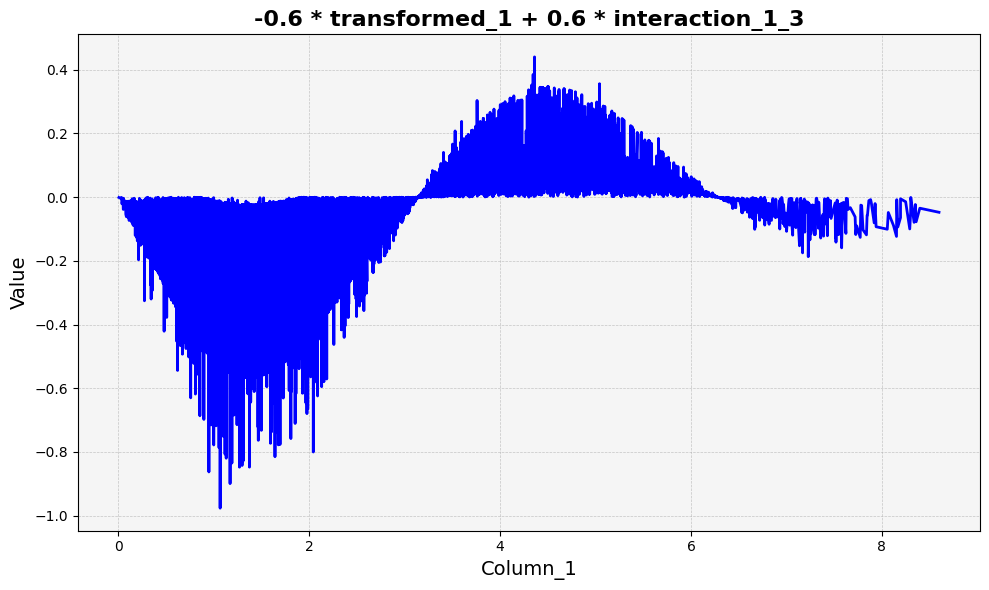

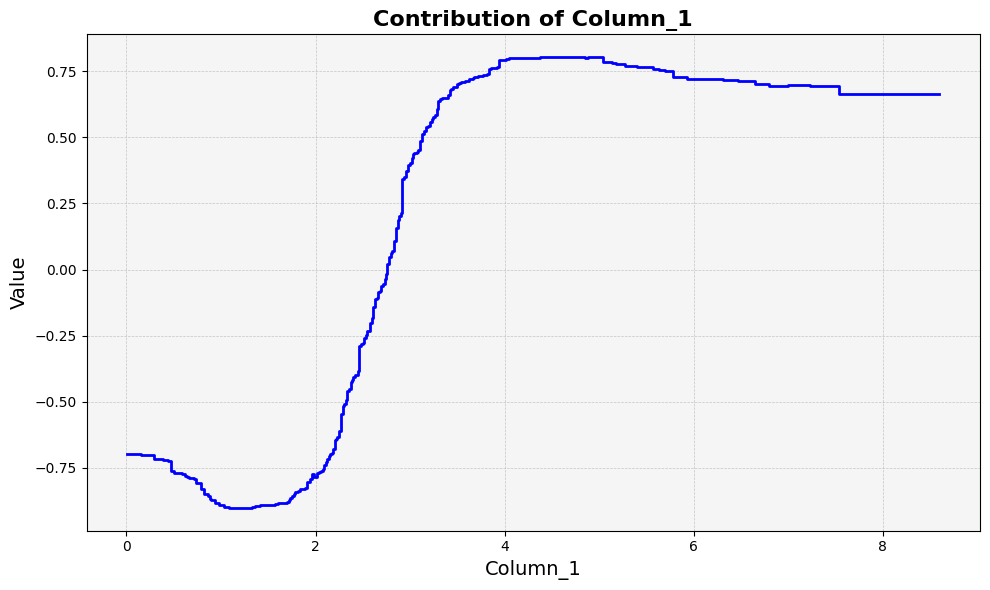

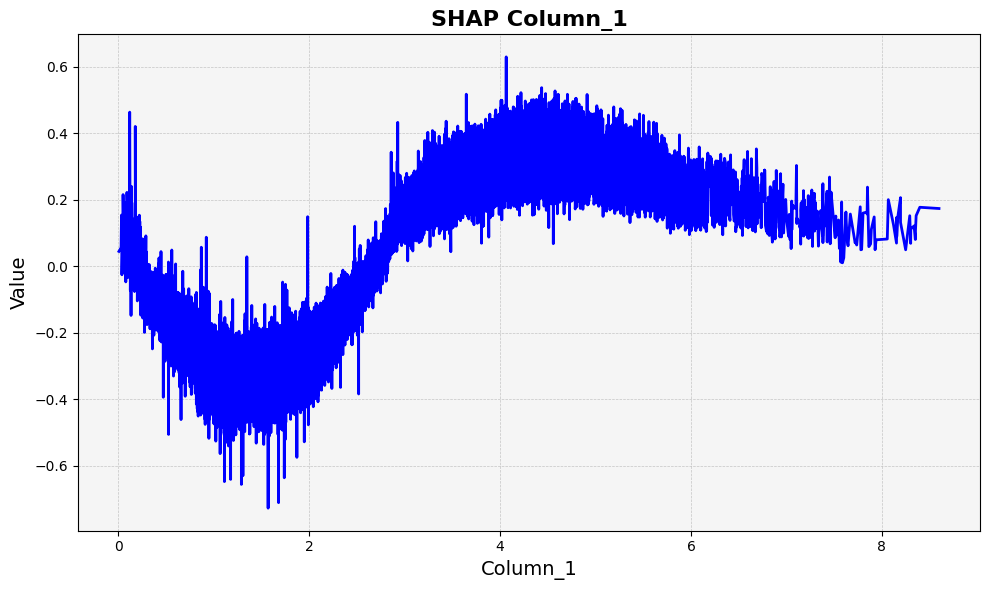

In [40]:

feature_df_1 = explainer.analyze_feature(1)
plot_line_chart(
    x=feature_1,
    y=-0.6 * transformed_1 * 0.5 * interaction_1_3,
    x_label="Column_1",
    y_label="Value",
    title="-0.6 * transformed_1 + 0.6 * interaction_1_3",
)
feature_plot(
    feature_df_1, show_min_max=False, col_min=X[:, 1].min(), col_max=X[:, 1].max()
)
plot_line_chart(
    x=feature_1,
    y=shap_values.values[:, 1],
    x_label="Column_1",
    y_label="Value",
    title="SHAP Column_1",
)

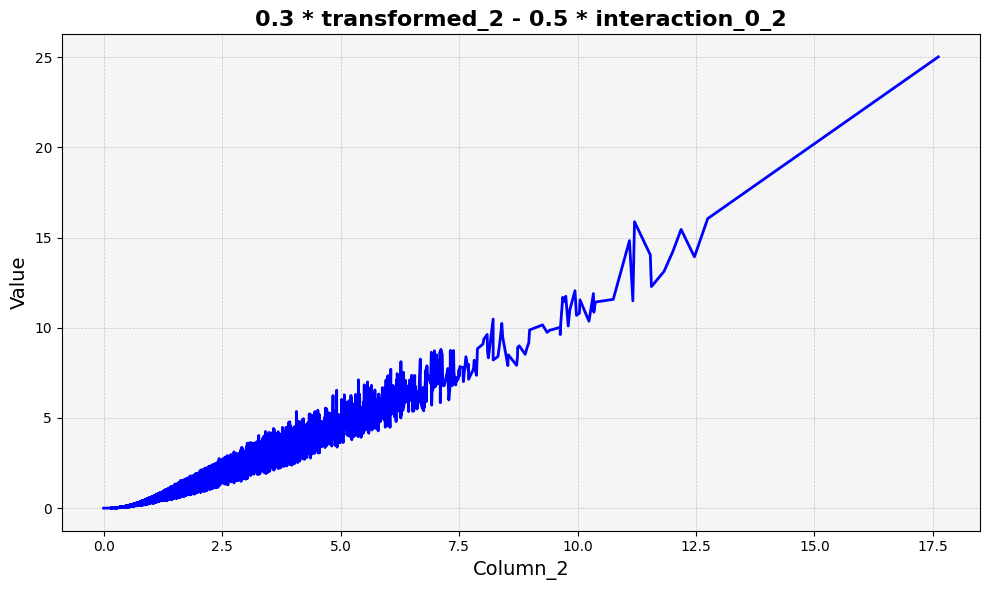

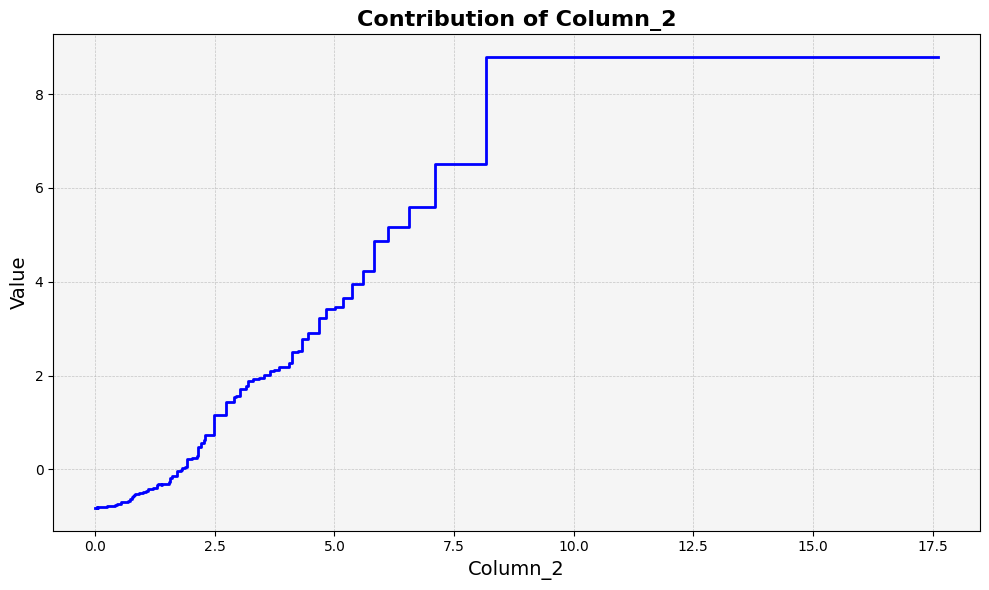

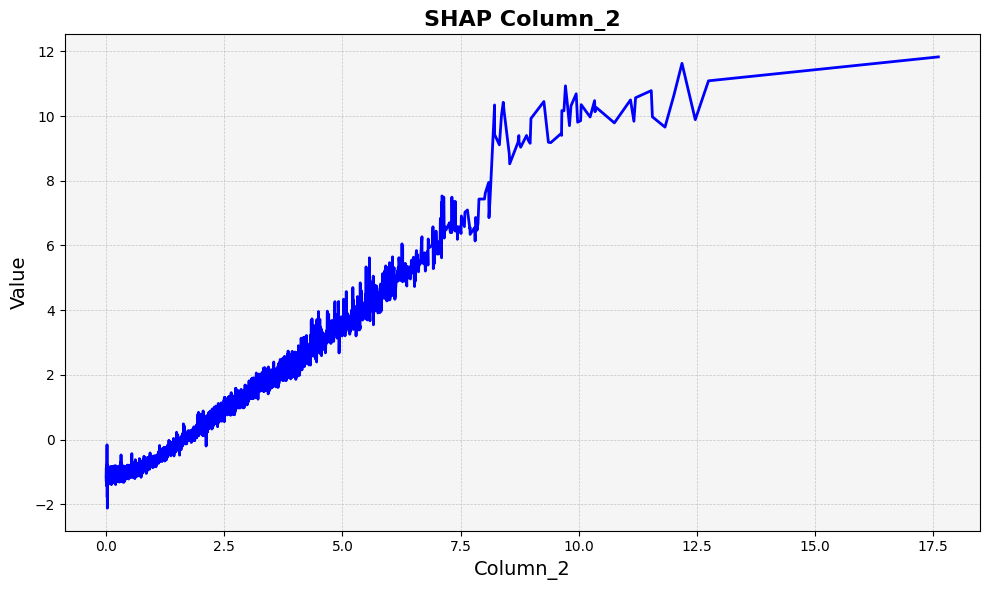

In [41]:
# Feature 2 Analysis
feature_df_2 = explainer.analyze_feature(2)
plot_line_chart(
    x=feature_2,
    y=0.3 * transformed_2 + 0.6 * interaction_0_2,
    x_label="Column_2",
    y_label="Value",
    title="0.3 * transformed_2 - 0.5 * interaction_0_2",
)
feature_plot(
    feature_df_2, show_min_max=False, col_min=X[:, 2].min(), col_max=X[:, 2].max()
)
plot_line_chart(
    x=feature_2,
    y=shap_values.values[:, 2],
    x_label="Column_2",
    y_label="Value",
    title="SHAP Column_2",
)

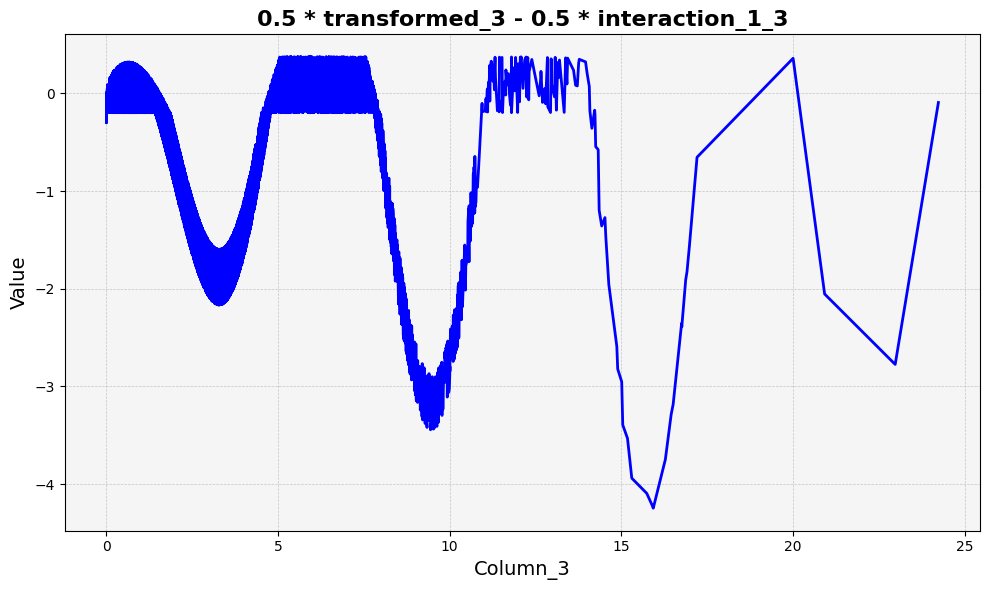

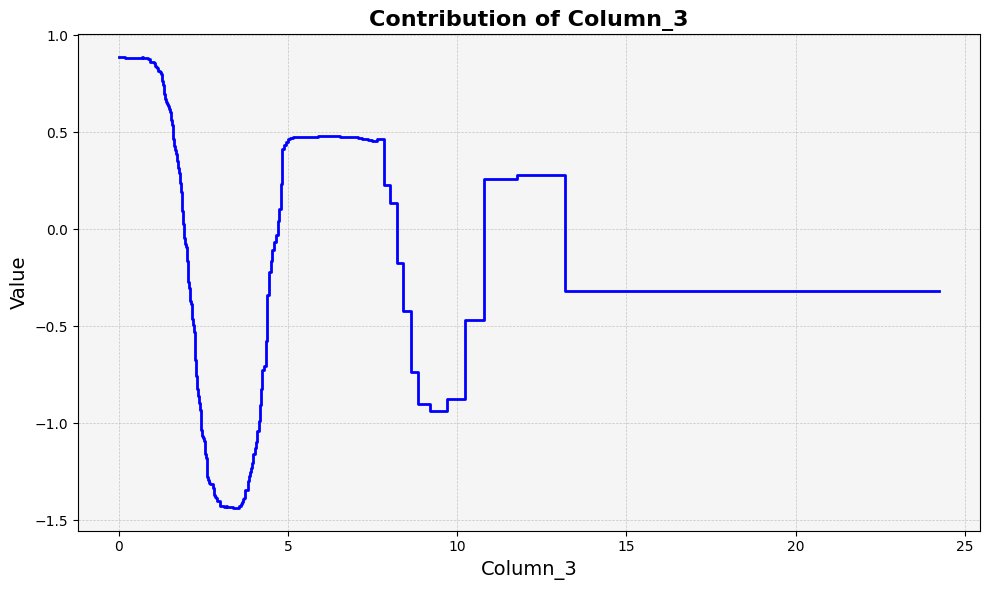

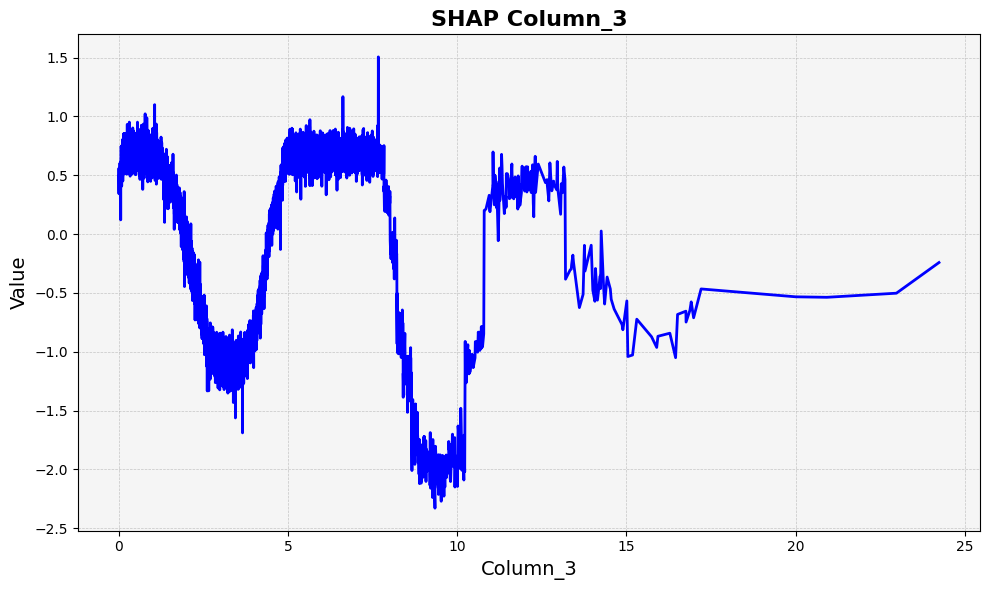

In [42]:
# Feature 3 Analysis
feature_df_3 = explainer.analyze_feature(3)
plot_line_chart(
    x=feature_3,
    y=0.5 * transformed_3 - 0.5 * interaction_1_3,
    x_label="Column_3",
    y_label="Value",
    title="0.5 * transformed_3 - 0.5 * interaction_1_3",
)
feature_plot(
    feature_df_3, show_min_max=False, col_min=X[:, 3].min(), col_max=X[:, 3].max()
)
plot_line_chart(
    x=feature_3,
    y=shap_values.values[:, 3],
    x_label="Column_3",
    y_label="Value",
    title="SHAP Column_3",
)

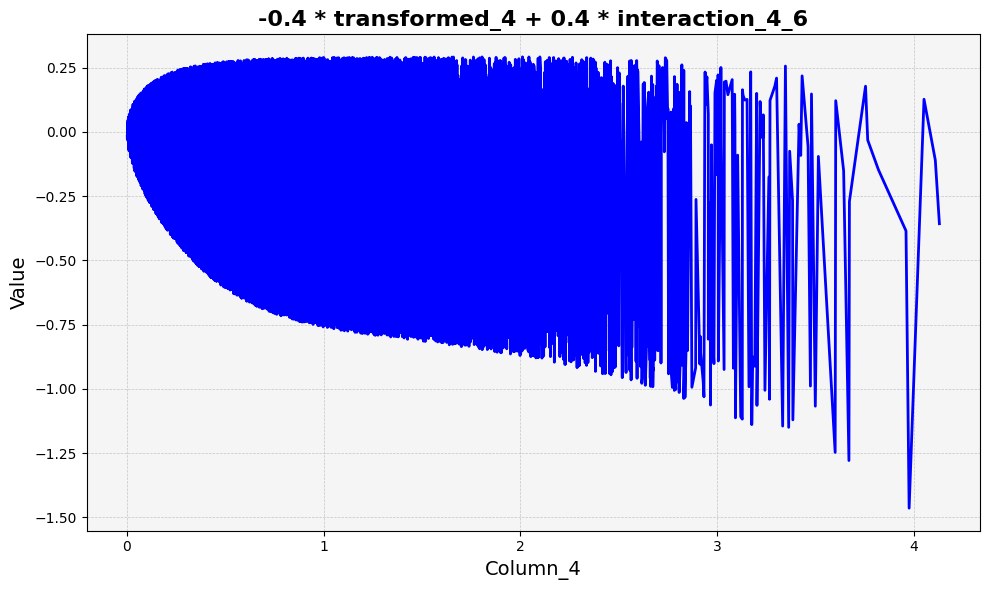

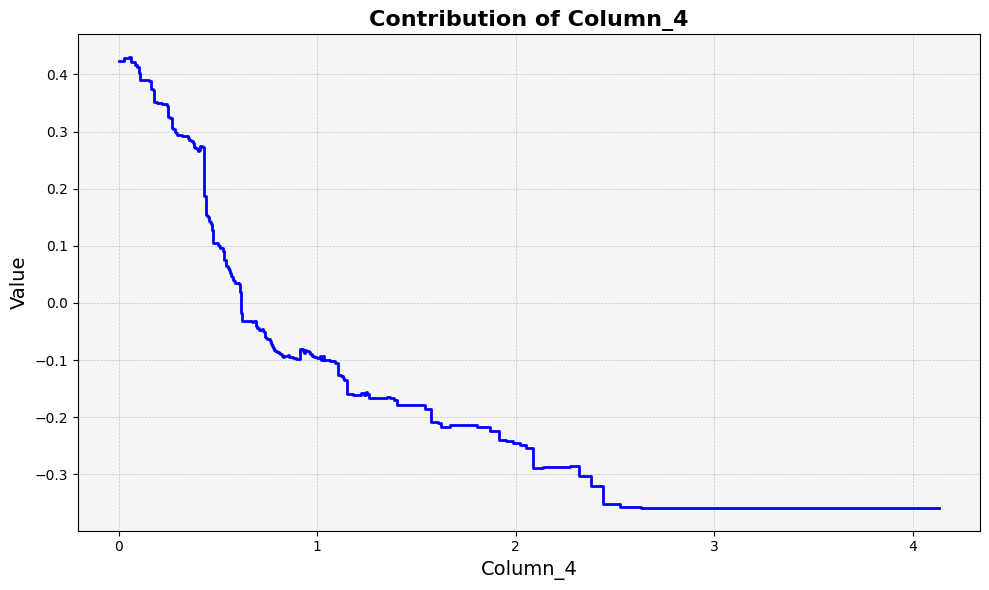

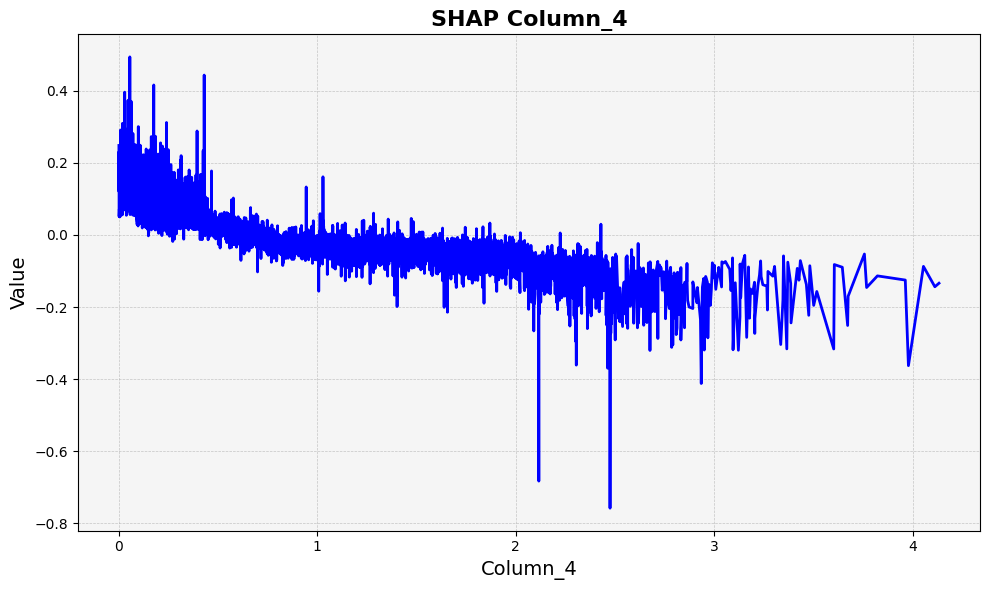

In [43]:
# Feature 4 Analysis
feature_df_4 = explainer.analyze_feature(4)
plot_line_chart(
    x=feature_4,
    y=-0.4 * transformed_4 + 0.4 * interaction_4_6,
    x_label="Column_4",
    y_label="Value",
    title="-0.4 * transformed_4 + 0.4 * interaction_4_6",
)
feature_plot(
    feature_df_4, show_min_max=False, col_min=X[:, 4].min(), col_max=X[:, 4].max()
)
plot_line_chart(
    x=feature_4,
    y=shap_values.values[:, 4],
    x_label="Column_4",
    y_label="Value",
    title="SHAP Column_4",
)

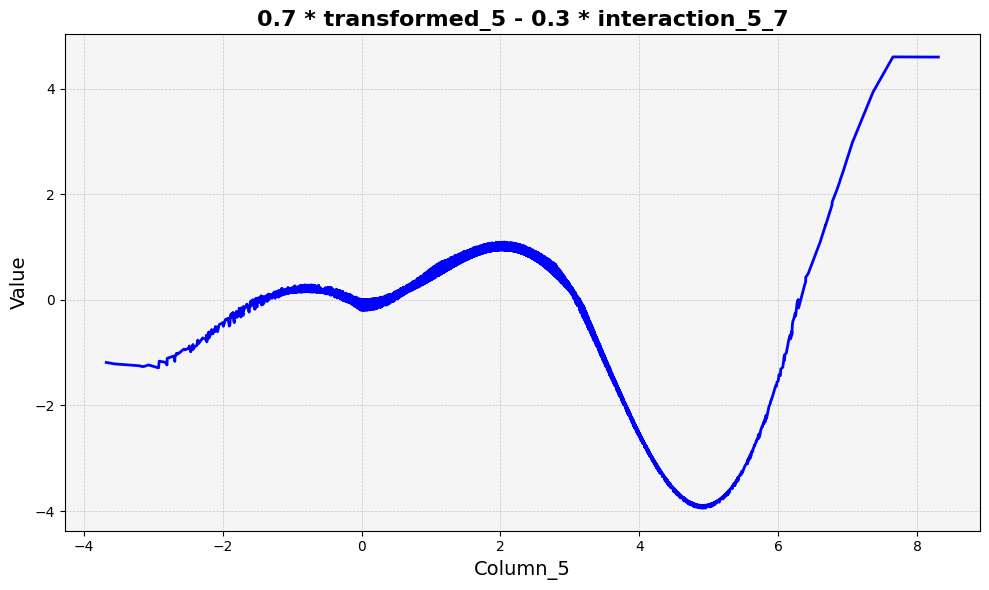

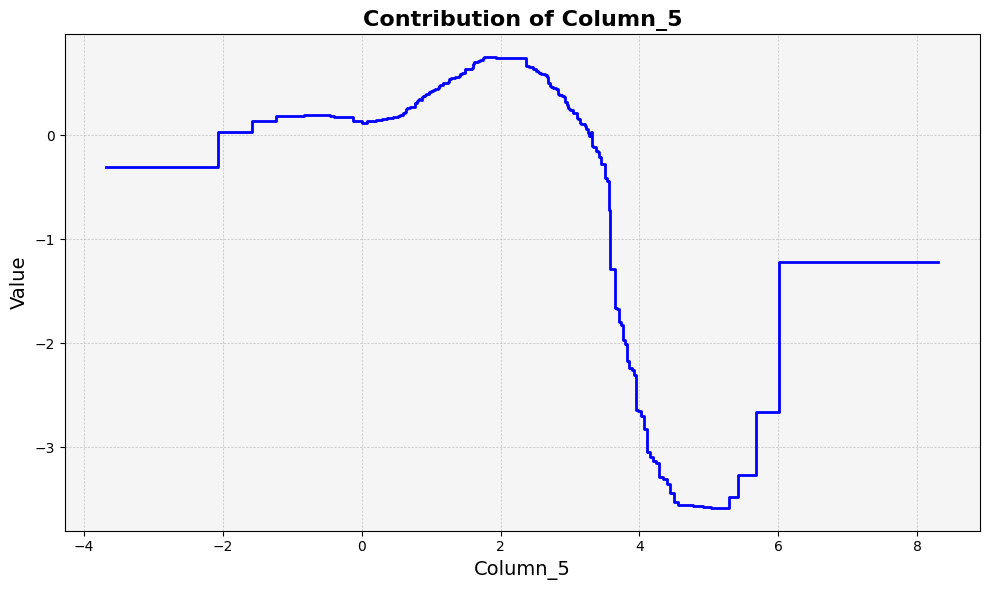

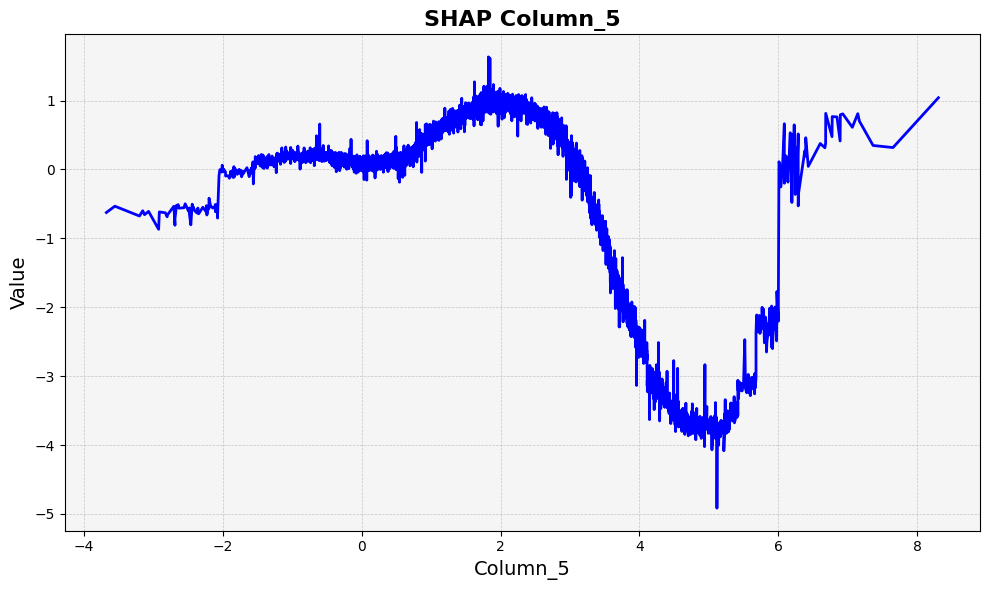

In [44]:
# Feature 5 Analysis
feature_df_5 = explainer.analyze_feature(5)
plot_line_chart(
    x=feature_5,
    y=0.7 * transformed_5 - 0.3 * interaction_5_7,
    x_label="Column_5",
    y_label="Value",
    title="0.7 * transformed_5 - 0.3 * interaction_5_7",
)
feature_plot(
    feature_df_5, show_min_max=False, col_min=X[:, 5].min(), col_max=X[:, 5].max()
)
plot_line_chart(
    x=feature_5,
    y=shap_values.values[:, 5],
    x_label="Column_5",
    y_label="Value",
    title="SHAP Column_5",
)

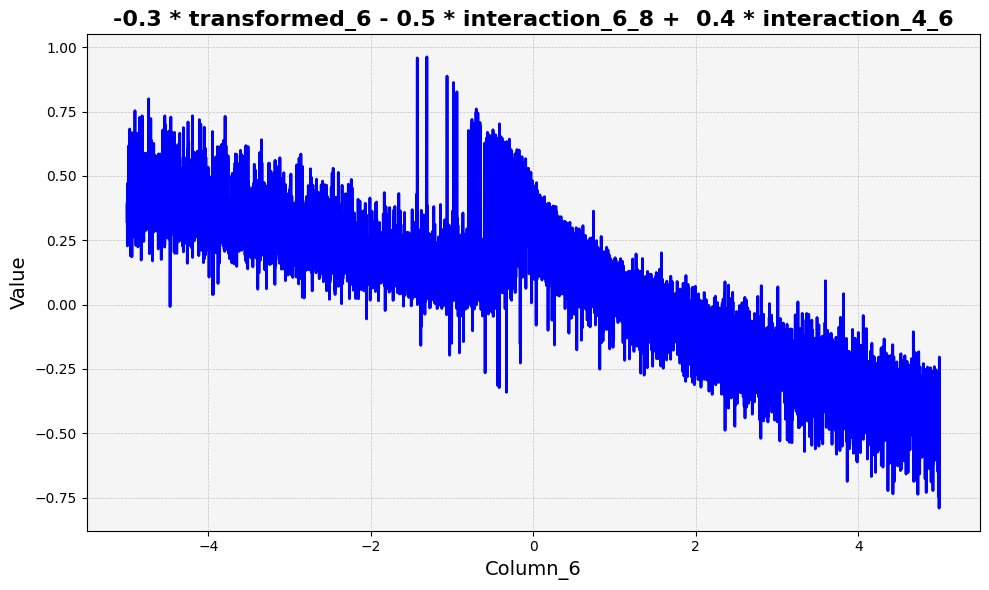

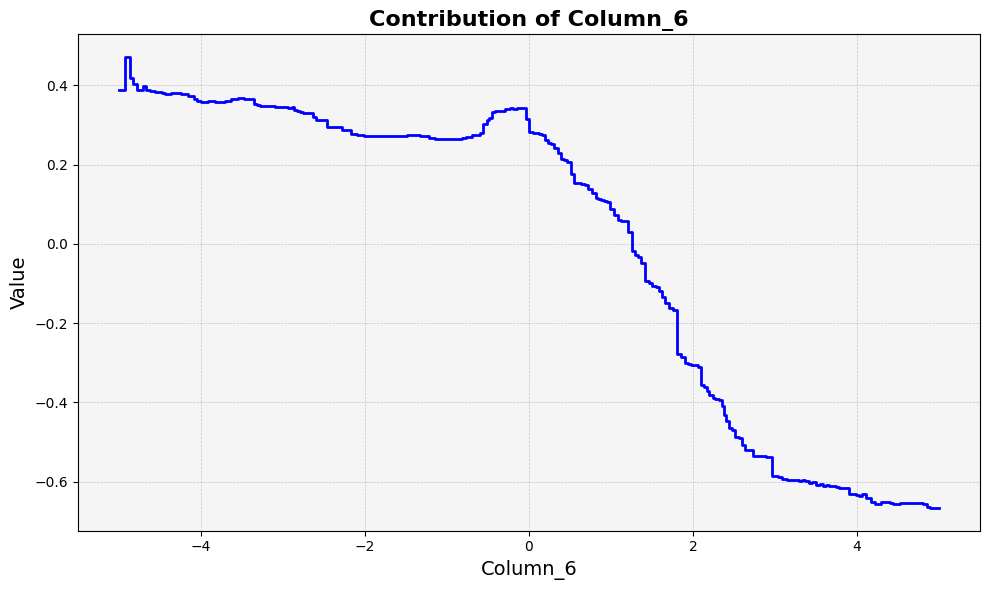

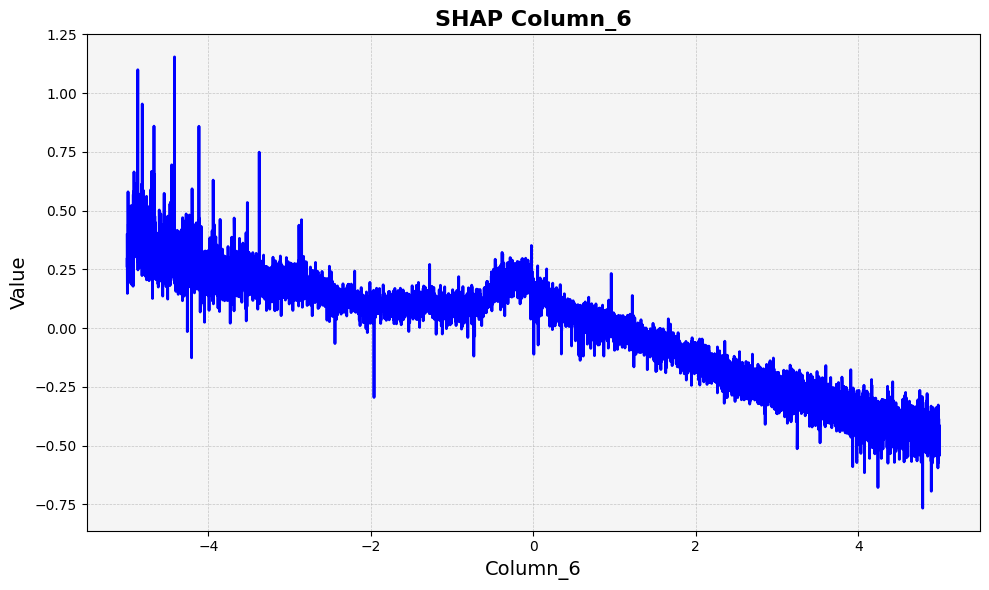

In [45]:
# Feature 6 Analysis
feature_df_6 = explainer.analyze_feature(6)
plot_line_chart(
    x=feature_6,
    y=-0.3 * transformed_6 + 0.5 * interaction_6_8 + 0.4 * interaction_4_6,
    x_label="Column_6",
    y_label="Value",
    title="-0.3 * transformed_6 - 0.5 * interaction_6_8 +  0.4 * interaction_4_6",
)
feature_plot(
    feature_df_6, show_min_max=False, col_min=X[:, 6].min(), col_max=X[:, 6].max()
)
plot_line_chart(
    x=feature_6,
    y=shap_values.values[:, 6],
    x_label="Column_6",
    y_label="Value",
    title="SHAP Column_6",
)

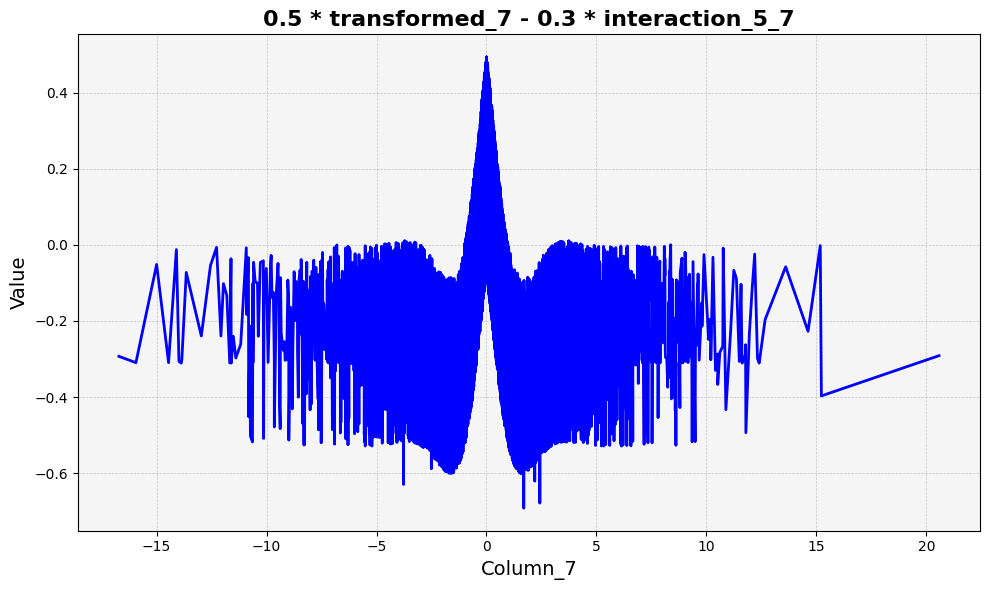

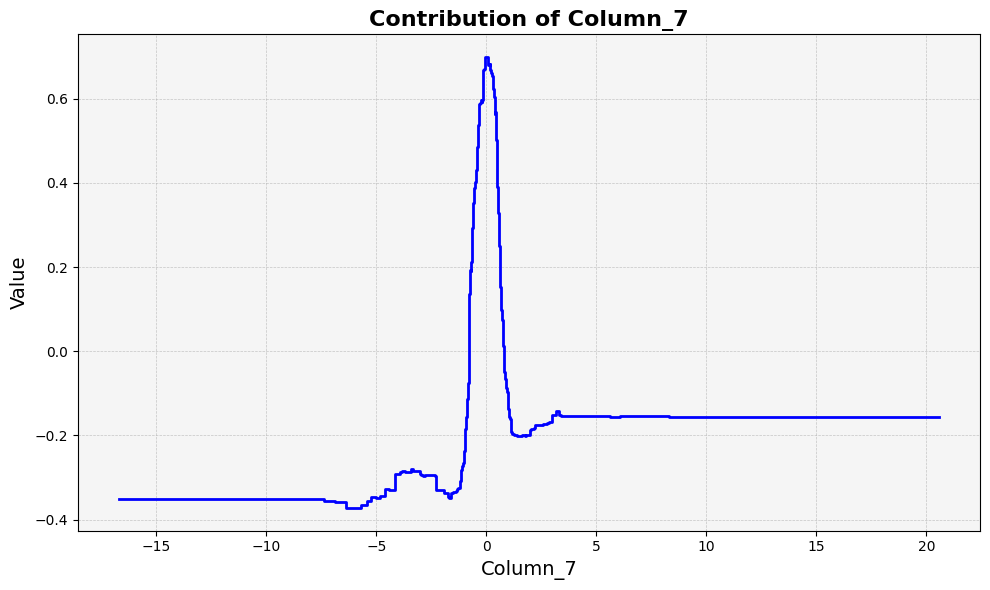

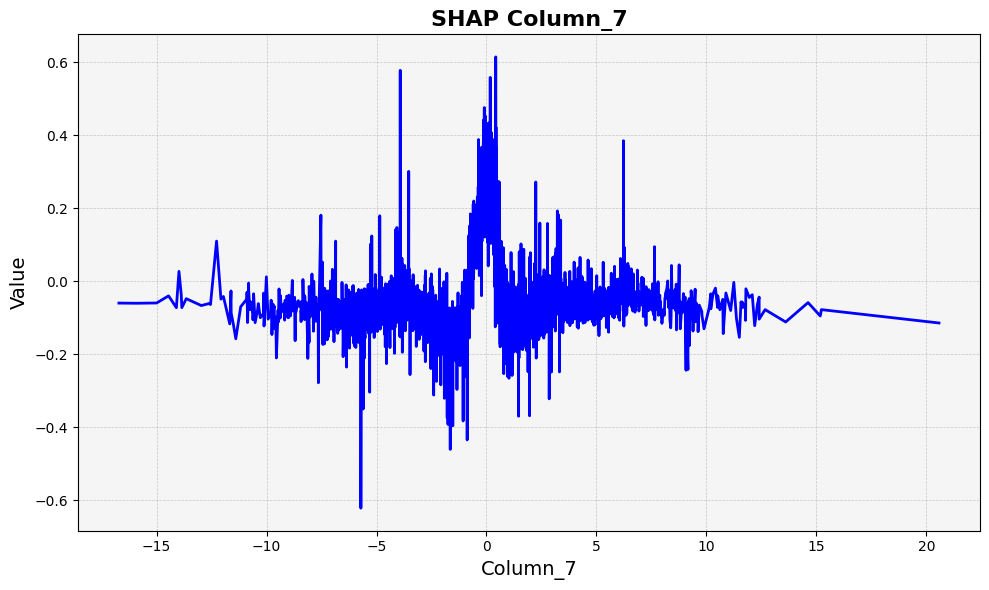

In [46]:
# Feature 7 Analysis
feature_df_7 = explainer.analyze_feature(7)
plot_line_chart(
    x=feature_7,
    y=0.5 * transformed_7 - 0.3 * interaction_5_7,
    x_label="Column_7",
    y_label="Value",
    title="0.5 * transformed_7 - 0.3 * interaction_5_7",
)
feature_plot(
    feature_df_7, show_min_max=False, col_min=X[:, 7].min(), col_max=X[:, 7].max()
)
plot_line_chart(
    x=feature_7,
    y=shap_values.values[:, 7],
    x_label="Column_7",
    y_label="Value",
    title="SHAP Column_7",
)

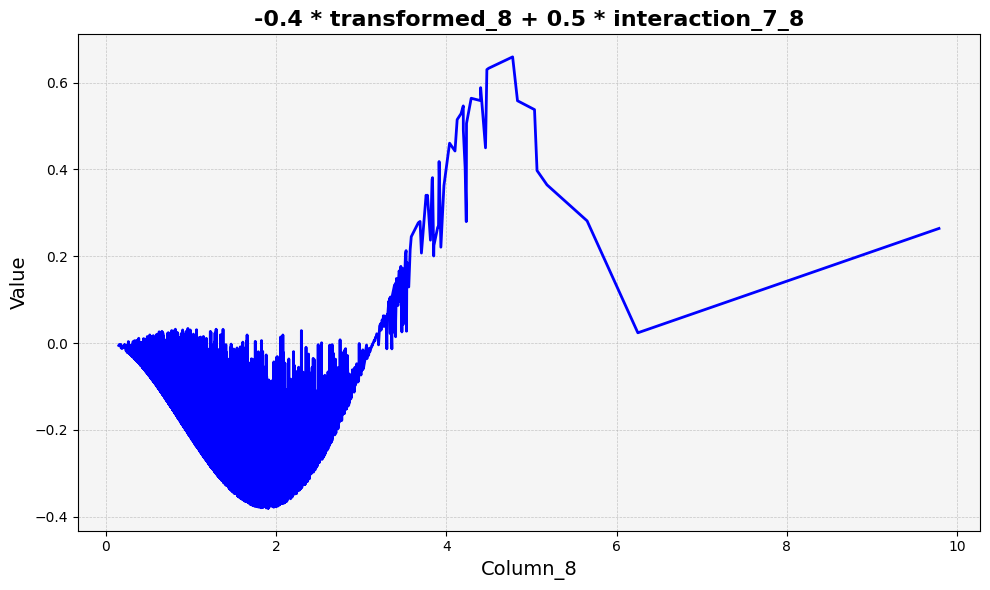

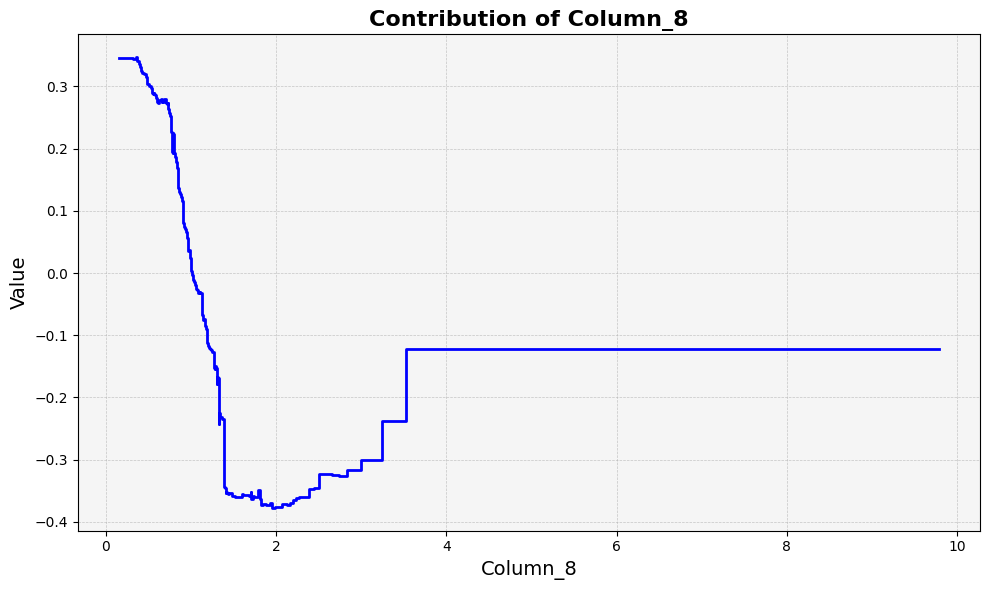

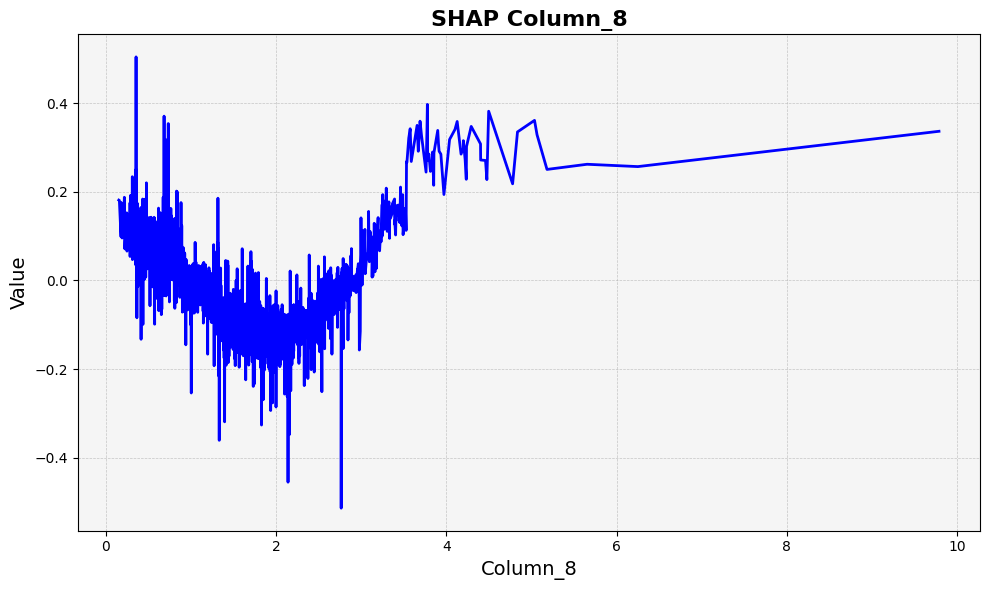

In [47]:
# Feature 8 Analysis
feature_df_8 = explainer.analyze_feature(8)
plot_line_chart(
    x=feature_8,
    y=-0.4 * transformed_8 + 0.5 * interaction_6_8,
    x_label="Column_8",
    y_label="Value",
    title="-0.4 * transformed_8 + 0.5 * interaction_7_8",
)
feature_plot(
    feature_df_8, show_min_max=False, col_min=X[:,8].min(), col_max=X[:, 8].max()
)
plot_line_chart(
    x=feature_8,
    y=shap_values.values[:, 8],
    x_label="Column_8",
    y_label="Value",
    title="SHAP Column_8",
)

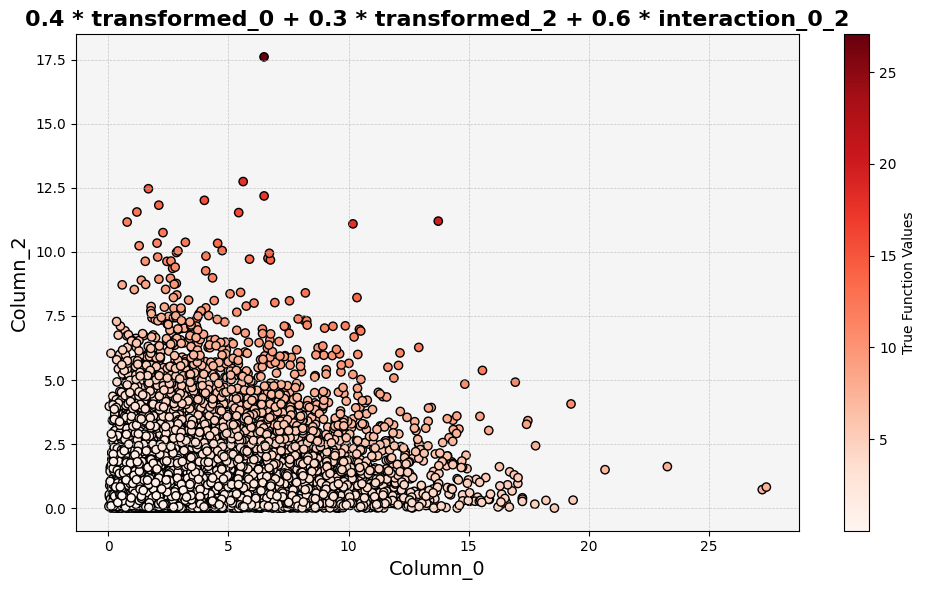

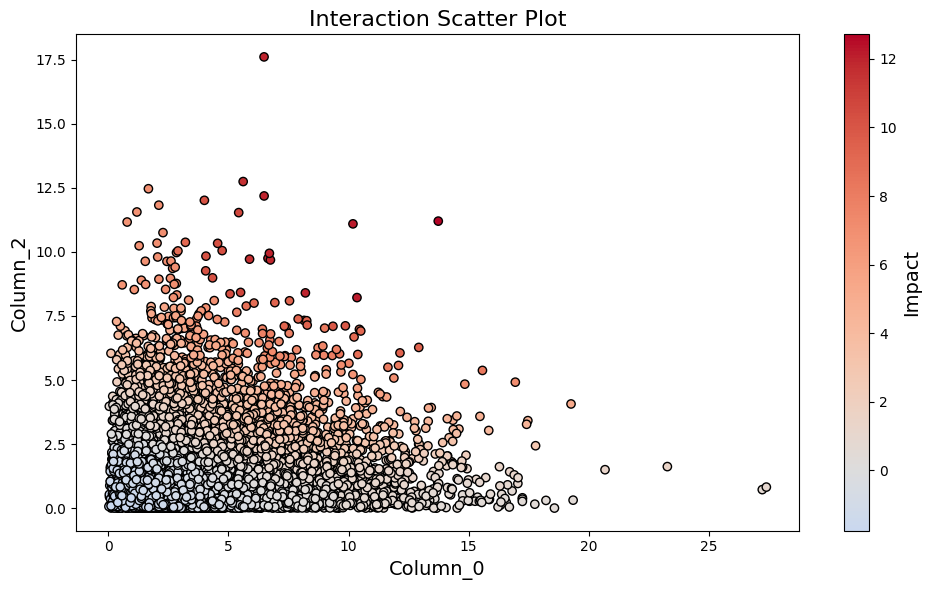

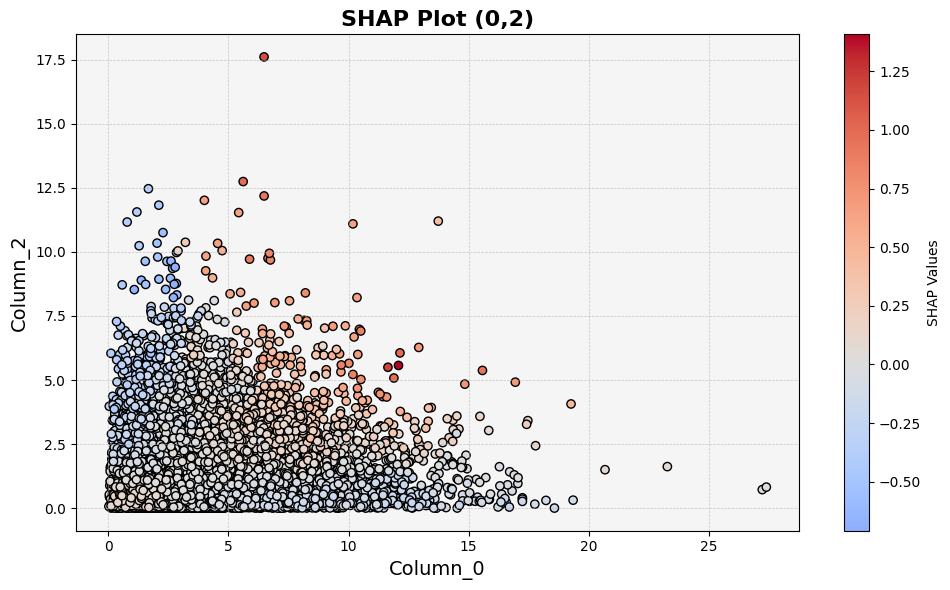

In [48]:
# Interaction Analysis: Feature 0 & Feature 1
df_01 = explainer.analyze_interaction(0, 2)
plot_scatter_chart(
    feature_0,
    feature_2,
    0.4 * transformed_0 + 0.3 * transformed_2 + 0.6 * interaction_0_2,
    x_label="Column_0",
    y_label="Column_2",
    title="0.4 * transformed_0 + 0.3 * transformed_2 + 0.6 * interaction_0_2",
    cbar_label="True Function Values",
)

interaction_scatter_plot(X, df_01, 0, 2, figsize = (10,6))

plot_scatter_chart(
    feature_0,
    feature_2,
    shap_interaction_values[:, 0, 2],
    x_label="Column_0",
    y_label="Column_2",
    title="SHAP Plot (0,2)",
    cbar_label="SHAP Values",
)

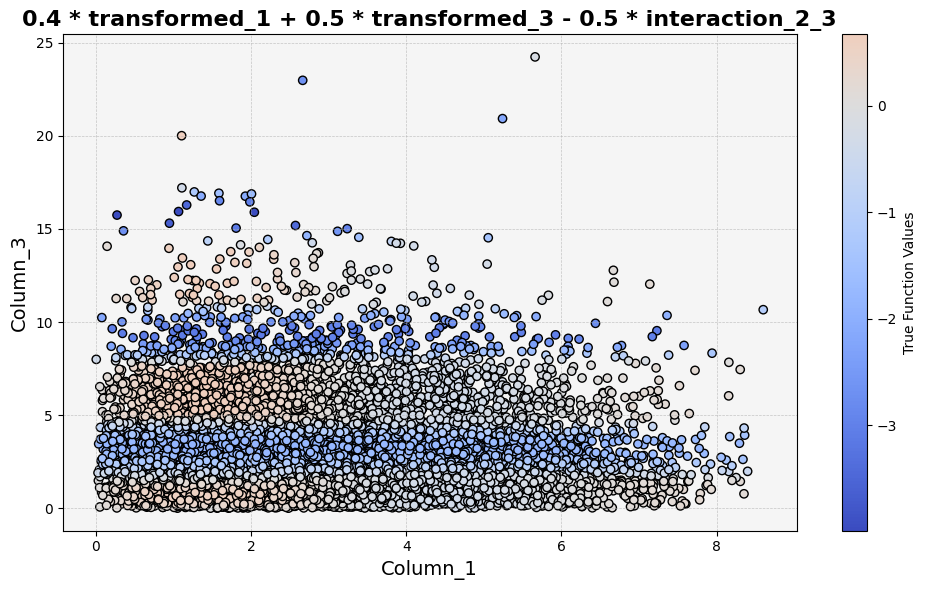

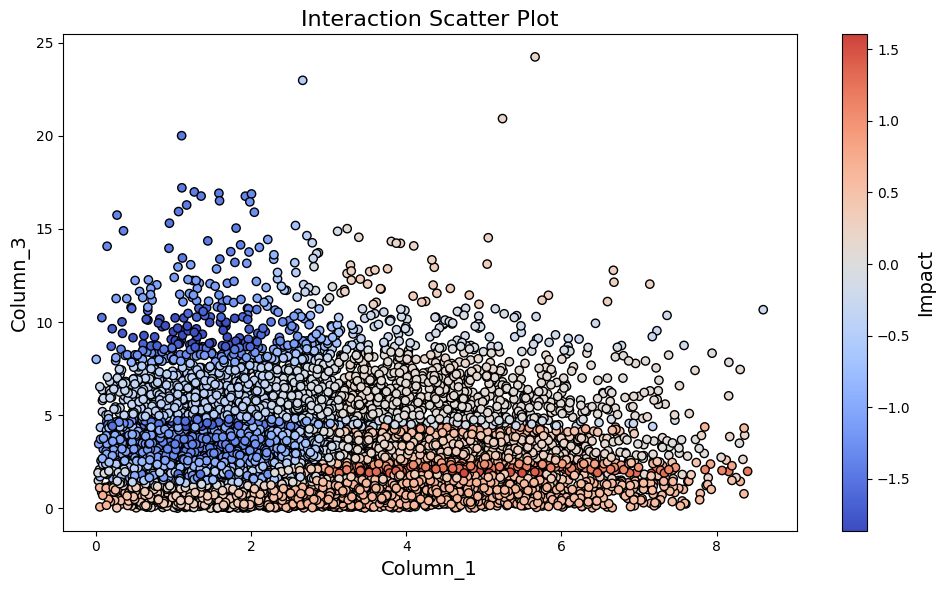

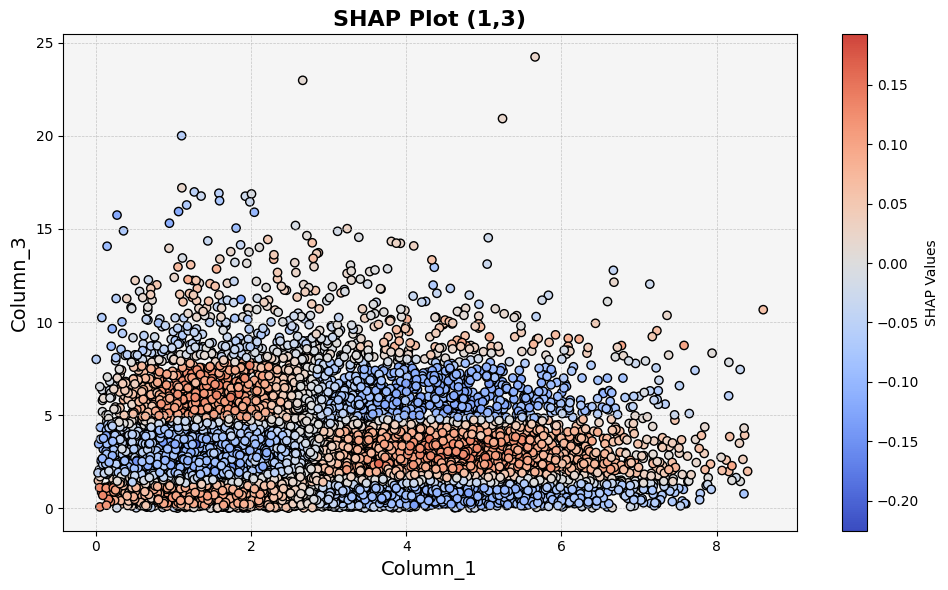

In [49]:
# Interaction Analysis: Feature 2 & Feature 3
df_23 = explainer.analyze_interaction(1, 3)
plot_scatter_chart(
    feature_1,
    feature_3,
    0.4 * transformed_1 + 0.5 * transformed_3 - 0.5 * interaction_1_3,
    x_label="Column_1",
    y_label="Column_3",
    title="0.4 * transformed_1 + 0.5 * transformed_3 - 0.5 * interaction_2_3",
    cbar_label="True Function Values",
)
interaction_scatter_plot(X, df_23, 1, 3,  figsize = (10,6))

plot_scatter_chart(
    feature_1,
    feature_3,
    shap_interaction_values[:, 1, 3],
    x_label="Column_1",
    y_label="Column_3",
    title="SHAP Plot (1,3)",
    cbar_label="SHAP Values",
)

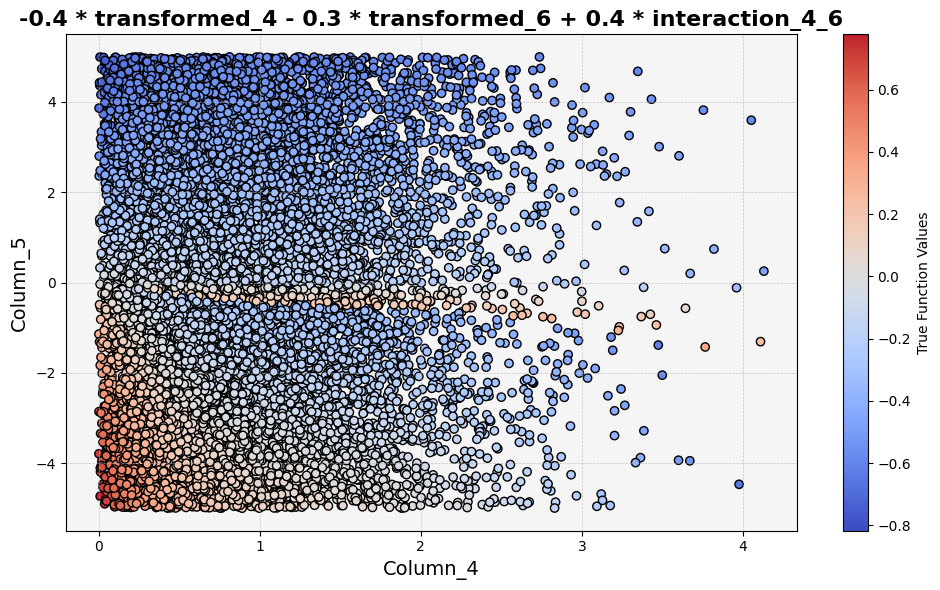

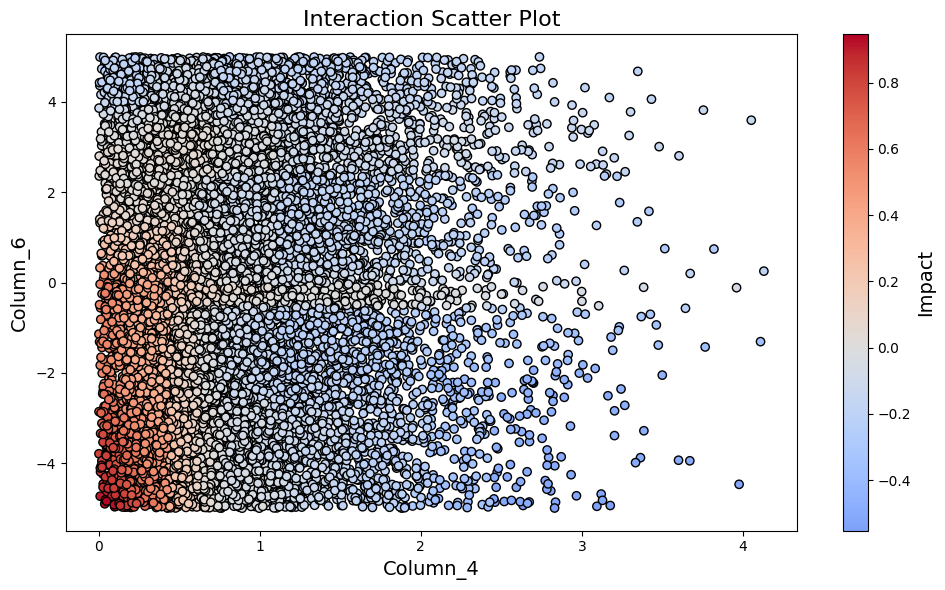

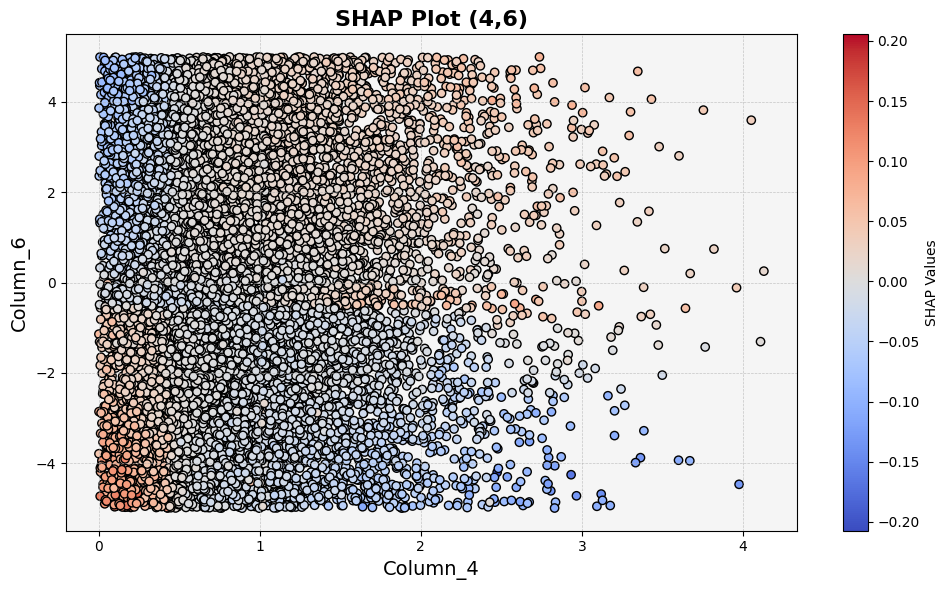

In [50]:
# Interaction Analysis: Feature 4 & Feature 5
df_45 = explainer.analyze_interaction(4, 6)
plot_scatter_chart(
    feature_4,
    feature_6,
    -0.4 * transformed_4 - 0.3 * transformed_6 + 0.4 * interaction_4_6,
    x_label="Column_4",
    y_label="Column_5",
    title="-0.4 * transformed_4 - 0.3 * transformed_6 + 0.4 * interaction_4_6",
    cbar_label="True Function Values",
)

interaction_scatter_plot(X, df_45, 4, 6,  figsize = (10,6))

plot_scatter_chart(
    feature_4,
    feature_6,
    shap_interaction_values[:, 4, 6],
    x_label="Column_4",
    y_label="Column_6",
    title="SHAP Plot (4,6)",
    cbar_label="SHAP Values",
)

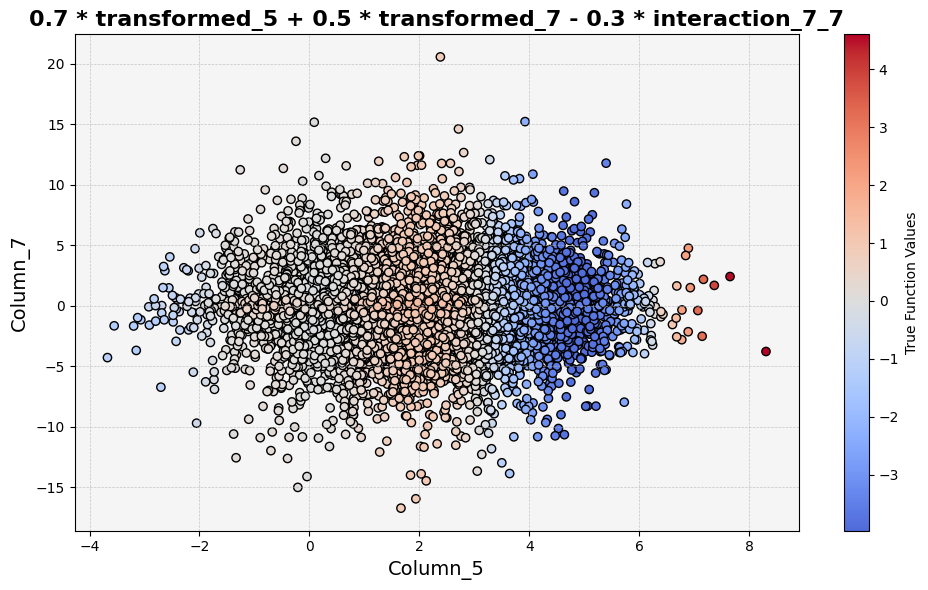

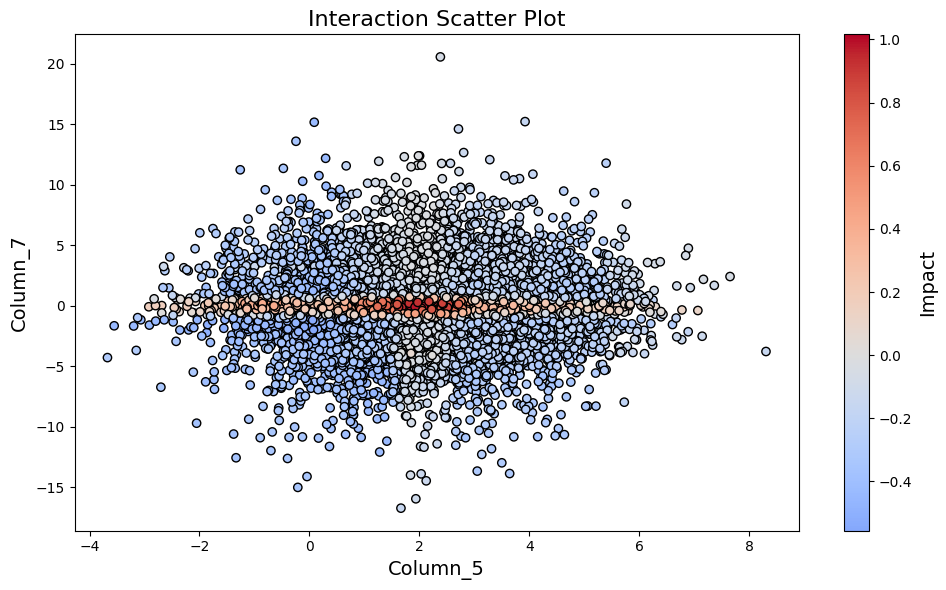

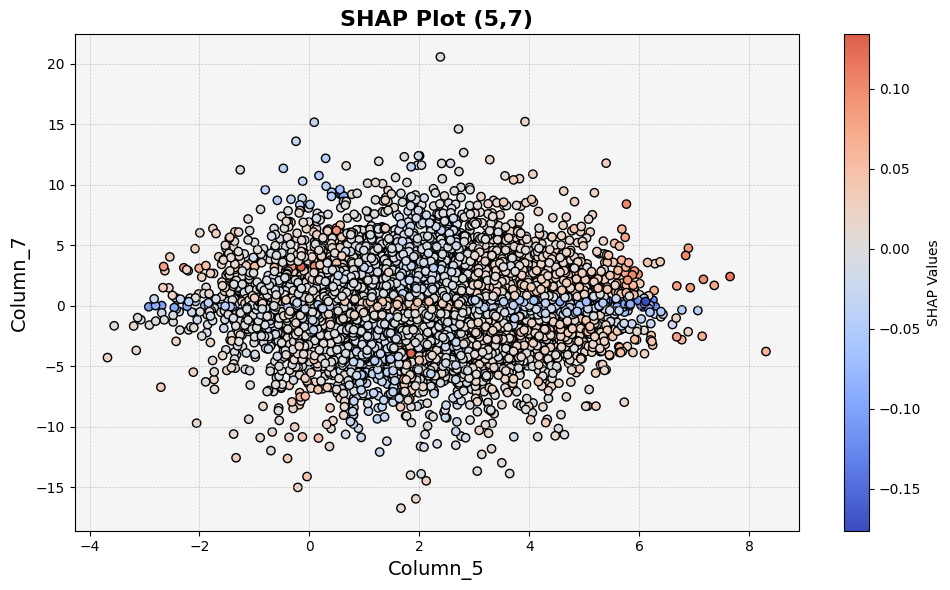

In [51]:
# Interaction Analysis: Feature 5 & Feature 7
df_67 = explainer.analyze_interaction(5, 7)
plot_scatter_chart(
    feature_5,
    feature_7,
    0.7 * transformed_5 + 0.5 * transformed_7 - 0.3 * interaction_5_7,
    x_label="Column_5",
    y_label="Column_7",
    title="0.7 * transformed_5 + 0.5 * transformed_7 - 0.3 * interaction_7_7",
    cbar_label="True Function Values",
)

interaction_scatter_plot(X, df_67, 5, 7,  figsize = (10,6))

plot_scatter_chart(
    feature_5,
    feature_7,
    shap_interaction_values[:, 5, 7],
    x_label="Column_5",
    y_label="Column_7",
    title="SHAP Plot (5,7)",
    cbar_label="SHAP Values",
)

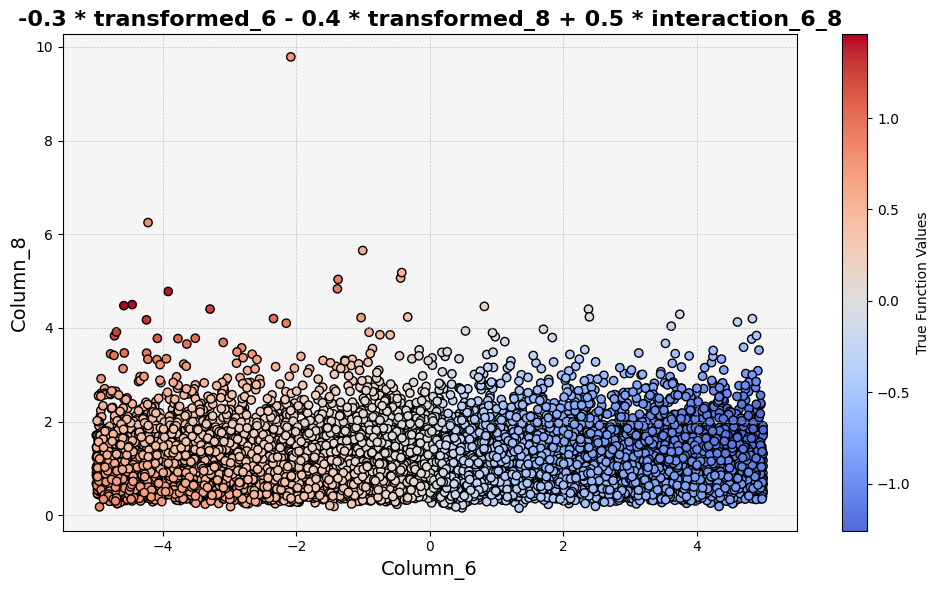

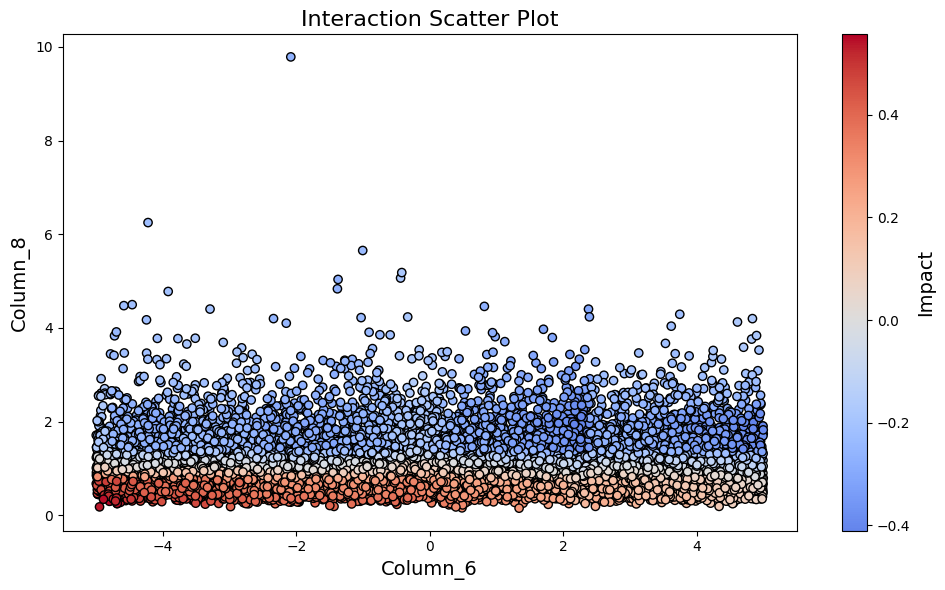

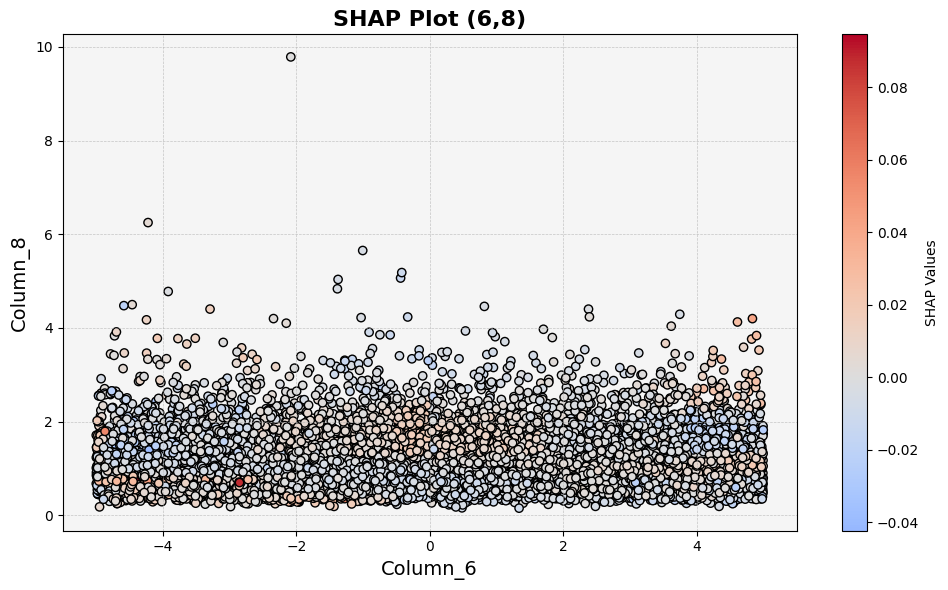

In [52]:
# Interaction Analysis: Feature 7 & Feature 8
df_78 = explainer.analyze_interaction(6, 8)
plot_scatter_chart(
    feature_6,
    feature_8,
    -0.3 * transformed_6 - 0.4 * transformed_8 + 0.5 * interaction_6_8,
    x_label="Column_6",
    y_label="Column_8",
    title="-0.3 * transformed_6 - 0.4 * transformed_8 + 0.5 * interaction_6_8",
    cbar_label="True Function Values",
)

interaction_scatter_plot(X, df_78, 6, 8,  figsize = (10,6))

plot_scatter_chart(
    feature_6,
    feature_8,
    shap_interaction_values[:, 6, 8],
    x_label="Column_6",
    y_label="Column_8",
    title="SHAP Plot (6,8)",
    cbar_label="SHAP Values",
)